In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import json
from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from signature.signature.stationary_signature import stationary_signature_from_path, G
from signature.signature.expected_signature import expected_signature, expected_stationary_signature
from scipy.optimize import minimize

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

In [2]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: total: 6min 7s
Wall time: 7min 49s


Text(0.5, 1.0, 'Driving Brownian motion W')

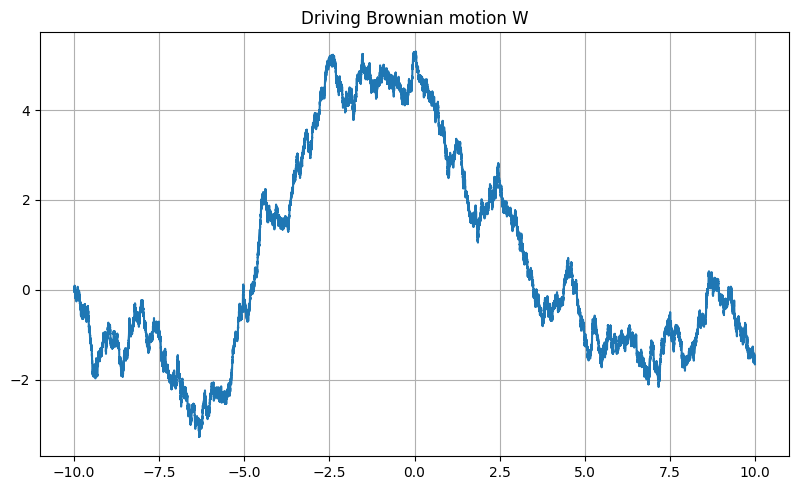

In [3]:
points_per_day = 20
T = 10

t_grid = np.linspace(-10, T, points_per_day * T * 365 + 1)

rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")


## OU representation

$$
d\sigma_t = \kappa (\theta - \sigma_t) dt + dW_t
$$

In [4]:
kappa = 15
theta = 0
nu = 1

ou = np.zeros_like(W)
ou[0] = theta
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(ou.size - 1):
    ou[i + 1] = ou[i] + kappa * (theta - ou[i]) * dt[i] + nu * dW[i]

X = np.concatenate([[0], np.cumsum(-0.5 * ou[:-1]**2 * np.diff(t_grid) + ou[:-1] * np.diff(W))])
S = np.exp(X)

Text(0.5, 1.0, 'OU trajectory')

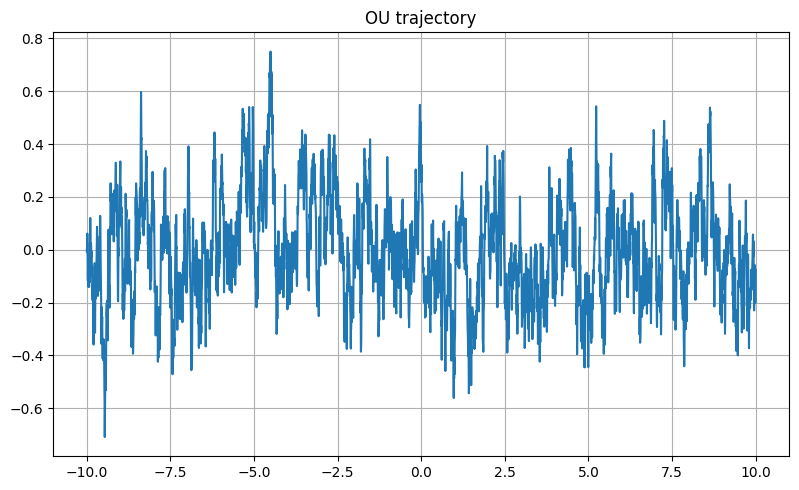

In [5]:
t_daily = t_grid[::points_per_day]
S_daily = S[::points_per_day]
X_daily = X[::points_per_day]
W_daily = W[::points_per_day]
ou_daily = ou[::points_per_day]

fig, ax = plt.subplots()
ax.plot(t_daily, ou_daily)
ax.set_title("OU trajectory")

In [6]:
path = np.vstack([t_daily, W_daily]).T
path_pos = np.vstack([t_daily[t_daily >= 0], W_daily[t_daily >= 0]]).T
N = 10
W_sig = ta.path_to_sequence(path=path_pos, trunc=N)

In [7]:
N = 10
lam = 10
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

In [8]:
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_221 = ta.from_dict({"221": 1}, trunc=N)

In [9]:
l_kappa = _2 * 1
tmp = _2 * 1

for i in range(N):
    tmp.update(tmp * (-kappa) + G(tmp) * lam)
    tmp.update(tmp.tensor_prod(_1))
    l_kappa.update(l_kappa + tmp)
    
ta.print(l_kappa)

1.0*2 + -5.0*21 + -25.0*211 + -375.0*2111 + -9375.0*21111 + -328125.0*211111 + -14765625.0*2111111 + -812109375.0*21111111 + -52787109375.0*211111111 + -3959033203125.0*2111111111


In [10]:
l_kappa_2 = _2 * 1
a = 1
for k in range(1, N + 1):
    a = a * (-kappa + lam * k)
    l_kappa_2.update(l_kappa_2 + _2.tensor_prod(_1.tensor_pow(k)) * a)
ta.print(l_kappa_2)

1.0*2 + -5.0*21 + -25.0*211 + -375.0*2111 + -9375.0*21111 + -328125.0*211111 + -14765625.0*2111111 + -812109375.0*21111111 + -52787109375.0*211111111 + -3959033203125.0*2111111111


In [11]:
ta.print((G(l_kappa_2) * lam - l_kappa_2 * kappa).tensor_prod(_1) + _2 - l_kappa_2)

336517822265625.0*2111111111


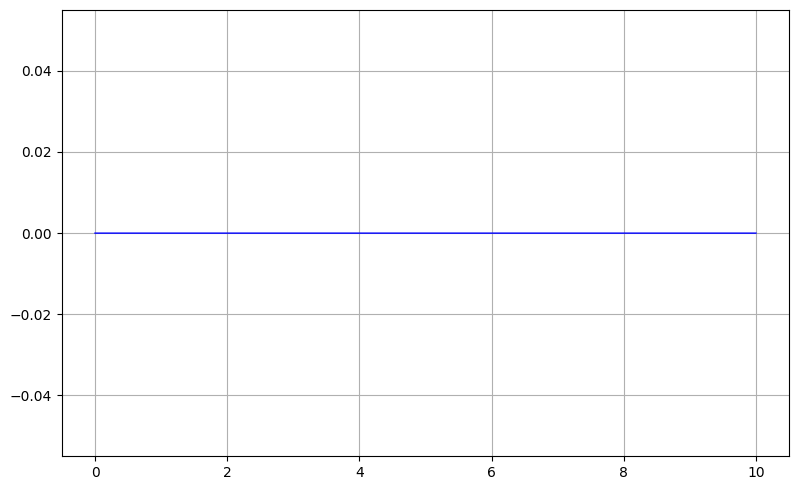

In [12]:
dif = (G(l_kappa_2) * (-lam) + l_kappa_2.proj("1") + l_kappa_2 * kappa)
ta.print(dif)

plt.plot(t_daily[t_daily >= 0], (SigS @ (dif)).real, "b", label=f"OU with $\mu={kappa}$", lw=1)

In [16]:
green = "#5b6c64"
copper = "#B56246"

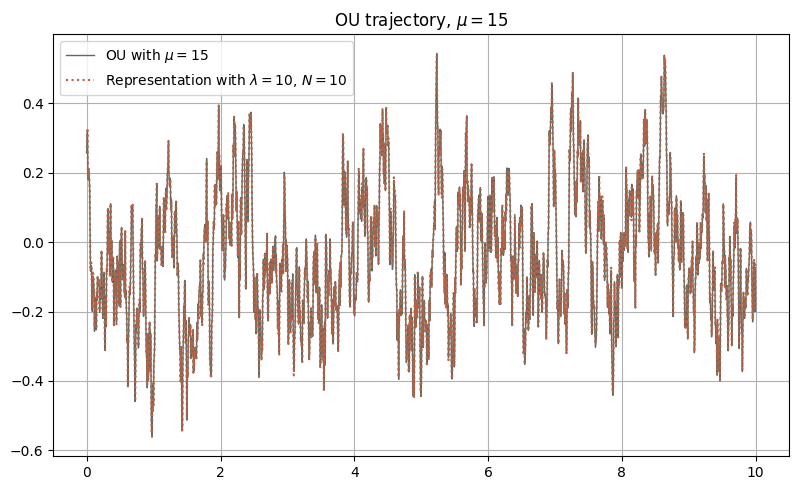

In [31]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

# ax.plot(t_daily[t_daily >= 0][idx_start:idx_start+step], (SigS @ (Ø * theta + _2)).real[idx_start:idx_start+step], "b", lw=1)
ax.plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, lw=1, label=f"OU with $\mu={kappa}$")
ax.plot(t_daily[t_daily >= 0], (SigS @ (Ø * theta + l_kappa)).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$", lw=1.5)
ax.set_title(f"OU trajectory, $\mu={kappa}$")
ax.legend()

In [18]:
s0 = ou_daily[t_daily >= 0][0]
nu = 1
theta = 0

l_OU = (Ø * s0 + _1 * kappa * theta + _2 * nu).tensor_prod((-kappa * _1).shuffle_exp(12))

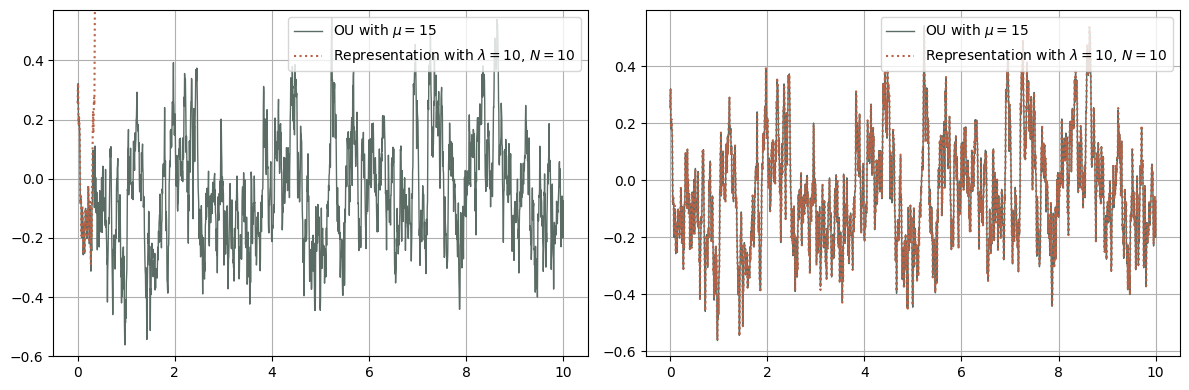

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

idx_start = 0
step = 500

# ax.plot(t_daily[t_daily >= 0][idx_start:idx_start+step], (SigS @ (Ø * theta + _2)).real[idx_start:idx_start+step], "b", lw=1)
ax[0].plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, lw=1, label=f"OU with $\mu={kappa}$")
ax[0].plot(t_daily[t_daily >= 0], (W_sig @ l_OU).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$", lw=1.5)
# ax[0].set_title(f"OU trajectory, $\mu={kappa}$")
ax[0].set_ylim([-0.6, 0.57])
ax[0].legend(loc=1)

ax[1].plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, lw=1, label=f"OU with $\mu={kappa}$")
ax[1].plot(t_daily[t_daily >= 0], (SigS @ (Ø * theta + l_kappa)).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$", lw=1.5)
# ax[1].set_title(f"OU trajectory, $\mu={kappa}$")
ax[1].legend(loc=1)

fig.tight_layout()
fig.savefig("signature_ou_representation.pdf", format="pdf", transparent=True)